In [1]:
from netCDF4 import Dataset
import netCDF4 as netcdf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr
import xarray.ufuncs as xu
from scipy.interpolate import griddata
#from pyresample.geometry import SwathDefinition
#from pyresample.kd_tree import resample_nearest

In [2]:
hfr_loc = "./data/hf_radar_05_2020.nc"
hfrdata = xr.open_dataset(hfr_loc)
cmems_loc = "./data/CMEMS-global-analysis-forecast-phy-001-024-hourly-u-v.nc"
cmemsdata = xr.open_dataset(cmems_loc)

In [3]:
lat_hfr=hfrdata.variables['lat'][:]
lon_hfr=hfrdata.variables['lon'][:]
time_hfr=hfrdata.variables['time'][:]
u_hfr=hfrdata.variables['u'][:,:,:]
v_hfr=hfrdata.variables['v'][:,:,:]

lat_cmems=cmemsdata.variables['latitude'][:]
lon_cmems=cmemsdata.variables['longitude'][:]
time_cmems=cmemsdata.variables['time'][:]
u_cmems=cmemsdata.variables['uo'][:,:,:]
v_cmems=cmemsdata.variables['vo'][:,:,:]

In [50]:
time_hfr.values[3], time_cmems.values[3]

(numpy.datetime64('2020-05-01T03:00:00.000000000'),
 numpy.datetime64('2020-05-01T03:30:00.000000000'))

In [4]:
x_hfr, y_hfr = np.meshgrid(lon_hfr,lat_hfr)
hfr_meshx = x_hfr.ravel()
hfr_meshy = y_hfr.ravel()

x_cmems, y_cmems = np.meshgrid(lon_cmems,lat_cmems)
#cmems_meshx = x_cmems.ravel()
#cmems_meshy = y_cmems.ravel()
#cmems_meshu = u_cmems.values.ravel()
#cmems_meshv = v_cmems.values.ravel()
#indexc = ~np.isnan(cmems_meshu)
#cmems_meshu = cmems_meshu[indexc]
#cmems_meshv = cmems_meshv[indexc]
#cmems_meshx = cmems_meshx[indexc]
#cmems_meshy = cmems_meshy[indexc]
x_cmems.shape

(37, 37)

Put HFR U and V components onto the model grid

In [5]:
HFRU = []
HFRV = []
for i in enumerate(u_hfr[:,0,0]):
    u_nonan = np.nan_to_num(u_hfr[i[0],:,:], copy=True, nan=9999.0, posinf=None, neginf=None) 
    v_nonan = np.nan_to_num(v_hfr[i[0],:,:], copy=True, nan=9999.0, posinf=None, neginf=None) 
    
    #print(speed_nonan.ravel().shape)
    #i[0]
    #print(i[0])
    HFRU_i = griddata((hfr_meshx.ravel(), hfr_meshy.ravel()), u_nonan.ravel(), (x_cmems, y_cmems), method='linear')
    HFRV_i = griddata((hfr_meshx.ravel(), hfr_meshy.ravel()), v_nonan.ravel(), (x_cmems, y_cmems), method='linear')
 
    HFRU.append(np.array(HFRU_i))
    HFRV.append(np.array(HFRV_i))
HFRU = np.array(HFRU)
HFRV = np.array(HFRV)
HFRU.shape

(744, 37, 37)

In [6]:
HFR_U = np.ma.masked_where(HFRU > 250, HFRU)
HFR_V = np.ma.masked_where(HFRV > 250, HFRV)

Compute bias for U and V

In [7]:
MODEL_U = np.squeeze(u_cmems)
MODEL_V = np.squeeze(v_cmems)
MODEL_U.shape

(744, 37, 37)

In [31]:
HFR_SPEED=np.sqrt(HFR_U**2+HFR_V**2)
MODEL_SPEED=np.sqrt(MODEL_U**2+MODEL_V**2)

In [32]:
Udiff = HFR_U - MODEL_U
Vdiff = HFR_V - MODEL_V
SPEEDdiff = HFR_SPEED - MODEL_SPEED


(numpy.datetime64('2020-05-01T02:00:00.000000000'),
 numpy.datetime64('2020-05-01T02:30:00.000000000'))

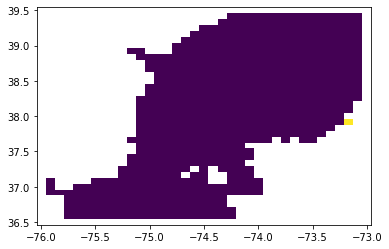

In [53]:
plt.pcolormesh(x_cmems, y_cmems,SPEEDdiff[2,:,:],shading='auto')
time_hfr.values[2], time_cmems.values[2]

In [8]:
a = HFR_U
b = MODEL_U

In [9]:
an=np.nan_to_num(a, copy=True, nan=0.0, posinf=None, neginf=None)
nz = np.count_nonzero(~np.isnan(an))
abar=np.sum(an,axis=0)/nz

bn=np.nan_to_num(b, copy=True, nan=0.0, posinf=None, neginf=None)
bnz = np.count_nonzero(~np.isnan(bn))
bbar=np.sum(bn,axis=0)/bnz

Ubias = abar - bbar

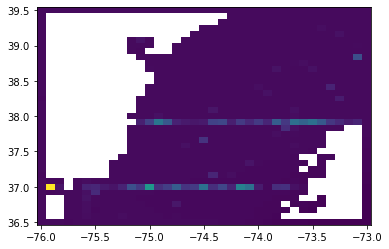

In [19]:
#fig = plt.figure(figsize=(8,12))
#proj = ccrs.PlateCarree()
#ax=fig.add_subplot(1,1,1,projection=proj)
#ax.set_extent([-76, -73, 36.5, 39.5])
plt.pcolormesh(x_cmems, y_cmems,Ubias,shading='auto')
# add colorbar
#cax,kw = mpl.colorbar()


In [24]:
Ubias

masked_array(
  data=[[0.0, -6.832195925480566e-06, -1.1508819509487185e-05, ...,
         -0.0007640330733814883, -0.0007486819408222623,
         -0.0007174494047093083],
        [0.0, --, --, ..., --, --, -0.0007611878629826904],
        [0.0, --, --, ..., --, --, -0.000788290229838771],
        ...,
        [0.0, --, --, ..., 4.140415277605767e-05, 4.396040790856547e-05,
         5.295258720705541e-05],
        [4.542408850765358e-06, --, --, ..., 3.443936305252694e-05,
         3.869906771757563e-05, 4.5545092720176696e-05],
        [4.478886180336479e-06, 0.0, 0.0, ..., 1.757756175560571e-05,
         2.33173096956264e-05, 2.7079468245641753e-05]],
  mask=[[False, False, False, ..., False, False, False],
        [False,  True,  True, ...,  True,  True, False],
        [False,  True,  True, ...,  True,  True, False],
        ...,
        [False,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [False, False, False, ..., Fals

In [12]:
a = HFR_V
b = MODEL_V

In [13]:
an=np.nan_to_num(a, copy=True, nan=0.0, posinf=None, neginf=None)
nz = np.count_nonzero(~np.isnan(an))
abar=np.sum(an,axis=0)/nz

bn=np.nan_to_num(b, copy=True, nan=0.0, posinf=None, neginf=None)
bnz = np.count_nonzero(~np.isnan(bn))
bbar=np.sum(bn,axis=0)/bnz

Vbias = abar - bbar

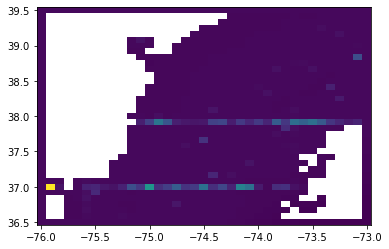

In [14]:
plt.pcolormesh(x_cmems, y_cmems,Vbias,shading='auto')

In [30]:
np.max(Ubias)


0.03191229578882796

In [29]:
np.max(Vbias)

0.031948183017478114